# Training a Neural Net

- Now that we have an undertanding of what *training* is, let's try it out!
- I'll use **Keras**, a wrapper that takes care of the low-level configuration of **TensorFlow**
- Only need the concepts of *neurons*, *layers*, *activtion function* etc. to build a NN in Keras 

# Training requires **data**

- Kaggle Higgs ML challenge

   - In 2014, Kaggle (online ML community) partnered with ATLAS to stage an ML competition
   - Teams were given signal ($H \rightarrow\tau \tau$) and background ($Z \rightarrow \tau \tau \;, t\bar{t} \;, W \rightarrow e/\mu$) simulation
   - The best classification performance (best *Approximate Median Significance*) wins!

    # I'll use this dataset to demo the training of a classification NN


In [5]:
import matplotlib
matplotlib.rcParams['font.size'] = 16
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing  

In [6]:
df = pd.read_csv('../HiggsML/training.csv')
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,349995,-999.000,71.989,36.548,5.042,-999.00,-999.000,-999.000,1.392,5.042,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.00,-999.000,-999.000,2.585,22.439,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.00,-999.000,-999.000,2.390,22.183,...,1,41.992,1.800,-0.166,-999.000,-999.00,-999.000,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.00,-999.000,-999.000,3.365,13.504,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.681611,b


# Data pre-processing

- extract -
   - variables that discriminate between signal and background (*features*)
   - labels that indicate whether the event is *signal* or *background*
   - weights that tell us how much that event should count in the loss function... Why?

- arrange this data in separate synchronous dataframe columns (or numpy arrays)

# Data pre-processing

- Split data into approximately equally-sized *training* and *test* set
    - training set used to directly alter weights and biases and minimise loss function
    - test set used to check performace and generalisability of network as batches passed through network
    
    
- loss(training) and loss(test) sets decreases as training proceeds
    - eventually, loss(training) $<$ loss(test) as network learns statitical fluctuations of training set
    - This is **over-training** and needs to be avoided at all costs... Why is it so bad?
        - In Keras usually terminate training once loss(training) $<<$ loss(test)

In [7]:
#extract features, labels, and event-weights
Labels=df['Label']

lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(Labels)
features = df.iloc[:,1:31]

X=features
y=np.ravel(labels)

print("Number of signal events = " + str(np.count_nonzero(y == 1)))
print("Number of background events = " + str(np.count_nonzero(y == 0)))

weights = df['Weight']
weights=np.ravel(weights) 

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.33, random_state=42, shuffle=True)

Number of signal events = 85667
Number of background events = 164333


# How do we weight MC events in general?

- we require our histograms to:
   - represent our expected data under some hypothesis

-  therefore the final weight must include:
   - the cross section of the process, the luminosity
   - weights (sometimes negative) produced by the MC generator
   - weights that correct for known deficiences in the simulation
       - e.g. b-tagging or trigger scale factors
   
$$ w_{final}  = \sigma * \mathcal{L} * w_{MC} * (w_{trigger} * w_{b-tagging} \dots etc.) $$

# What about when we are training an ML algorithm?

- **optimally**, we want our training simulation to look like our data

-  therefore the training simulation should include:
   - the cross section of the process??, ~~the luminosity of the dataset~~
   - weights (sometimes negative) produced by the MC generator
   - weights that correct for known deficiences in the simulation
       - e.g. b-tagging or trigger scale factors 

# In the case of a rare signal, this approach can lead to an undeperforming NN !

- NN aims to discriminate between labelled data classes: S and B ($t = 1,0$)
- The NN output, $p(x)$ (discriminator), is the predicted probability for the S class 
- Training NN minimises a **loss function**  
- The *binary cross-entropy* for weighted events becomes:
$$ C_{B} = \sum_i - \big[ ( t* \ln p(x_i))  + (1-t)*(\ln (1-p(x_i)) ) \big] * w_{i}$$

# weighting strategies
- 1. **ignore weights altogether**: 
     - the relative contribution of the S and B classes to the loss function will depend on how many MC events of each class you generated!! ¯\_(ツ)_/¯
     - relative contributions of processes within mixed background class won't correspond to the SM! ¯\_(ツ)_/¯
- 2. **use $w_{final}$**
   - theoretically correct *weighted mixture* of processes
   - rare signal hardly contributes to the loss function at all! 
      - classifying $\approx$ all events as background would give $\approx$ 100% accuracy
- 3. **use $w_{final}$: but give signal events a final constant weight such that** $$\sum w^b_i = \sum w^s_i$$

In [8]:
df_train = pd.DataFrame()
df_train["label"] = y_train
df_train["weights"] = weights_train

sigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
bkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])

print(sigSumWeights)

scale = (bkgSumWeights/sigSumWeights)
df_train.loc[df_train.label==1, "weights"] *= scale

modsigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])

print(modsigSumWeights)


final_weights_train = df_train["weights"]

465.42660577205487
275337.2613916108


# Define network 'architecture'

- How many neurons, how many layers?
- What activation function? What loss function?

In [9]:
model = Sequential()
model.add(Dense(15, input_dim=30, activation='relu', kernel_regularizer=None))
model.add(Dense(15, activation='relu', kernel_regularizer=None))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')   
model.fit(X_train, y_train, sample_weight=final_weights_train, epochs=8, batch_size=100, verbose=1)

2022-09-17 17:07:28.510425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 17:07:28.521575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 17:07:28.521957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 17:07:28.525228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mkidson/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_14214/4117420712.py", line 6, in <cell line: 6>
    model.fit(X_train, y_train, sample_weight=final_weights_train, epochs=8, batch_size=100, verbose=1)
  File "/home/mkidson/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
  File "/home/mkidson/.local/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py", line 102, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
tensorflow.python.framework.errors_impl.InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

During handling of the above exception, another exception occur

In [7]:
# plot discriminator values for "train" set
pred_train = model.predict(X_train)

dfNN = pd.DataFrame()
dfNN["labels"] = y_train
dfNN["predictions"] = pred_train
dfNN["weights"] = final_weights_train

signalVals = dfNN[dfNN['labels']== 1] 
backgroundVals = dfNN[dfNN['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
#plt.yscale('log')
plt.show()

2022-09-17 13:21:27.466066: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.5KiB (rounded to 7680)requested by op SameWorkerRecvDone
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-09-17 13:21:27.466151: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-09-17 13:21:27.466185: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 39, Chunks in use: 39. 9.8KiB allocated for chunks. 9.8KiB in use in bin. 700B client-requested in use in bin.
2022-09-17 13:21:27.466211: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 800B client-requested in use in bin.
2022-09-17 13:21:27.466234: I tensorf

ResourceExhaustedError: Graph execution error:

SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;bbcbbcbc25f95849;/job:localhost/replica:0/task:0/device:GPU:0;edge_9_IteratorGetNext;0:0
	 [[{{node IteratorGetNext/_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_710980]

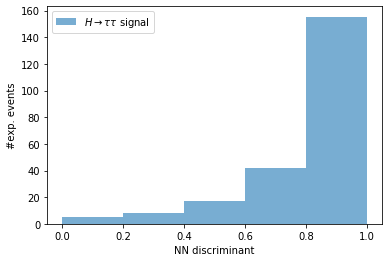

In [15]:
# plot discriminator values for "test" set
pred_test = model.predict(X_test)

dfNN = pd.DataFrame()
dfNN["labels"] = y_test
dfNN["predictions"] = pred_test
dfNN["weights"] = weights_test

signalVals = dfNN[dfNN['labels']== 1] 
backgroundVals = dfNN[dfNN['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

#bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
#plt.yscale('log')
plt.show()

In [9]:
def getSig(sigHist, bkgHist):

    #extract signifcance vs. discriminant.
    bins = sigHist[1]
    nSig = sigHist[0]
    nBkg = bkgHist[0]

    binCentres = (bins[:-1] + bins[1:]) / 2
    width = bins[1] - bins[0]
    sigmasNN = np.array([])
    sigmasVar = np.array([])

    for x in range(0,len(binCentres)):
        indices = [x, (len(binCentres)-1)] 
        if (nBkg[indices].sum() != 0):
            sigma = (nSig[indices].sum()) / ( np.sqrt(nBkg[indices].sum() + nBkg[indices].sum() ))
        else:
            sigma = 0.001
        sigmasNN = np.append(sigmasNN, sigma)
        
    return binCentres, sigmasNN

No handles with labels found to put in legend.


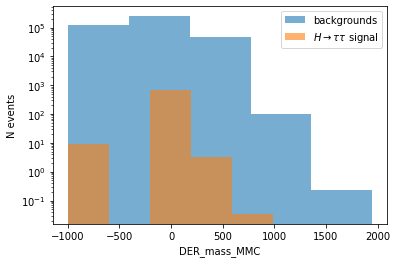

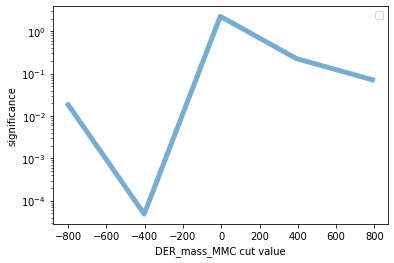

In [10]:
signalVals = df[df['Label']== "s"] 
backgroundVals = df[ df['Label']== "b"]

for var in df.columns:
    if( (var == "DER_mass_MMC") ):   
        plt.yscale('log')
        plt.xlabel(var)
        plt.ylabel("N events")
        bkgHist = plt.hist(backgroundVals[var], bins=5, weights=backgroundVals["Weight"], label="backgrounds", alpha=0.6)
        sigHist = plt.hist(signalVals[var], bins=5, weights=signalVals["Weight"], label=r"$H\rightarrow \tau\tau$ signal", alpha=0.6)
        binCentres, sigmas = getSig(sigHist, bkgHist) 
        plt.legend() 
        #make comparison plot
        fig, ax1 = plt.subplots()
        plt.xlabel(var + " cut value")
        plt.ylabel("significance")
        ax1.plot(binCentres, sigmas, lw=5, alpha=0.6)
        plt.legend() 
        plt.yscale('log')
        plt.show()

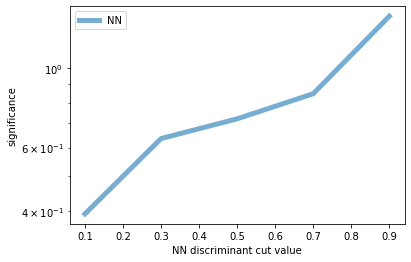

In [13]:
#make comparison plot
fig, ax1 = plt.subplots()
plt.xlabel("NN discriminant cut value")
plt.ylabel("significance")
plt.yscale('log')
binCentres, sigmasNN = getSig(sigHistNN, bkgHistNN)

ax1.plot(binCentres, sigmasNN, label="NN", lw=5, alpha=0.6)
plt.legend()    
plt.show()

In [ ]:
newModel = keras.models.load_model('/home/mkidson/gitRepos/Uni-Code/Honours/DS/Top_Tagging/models/constit_preprocessed_no_weights_processing_1200000_jets_80_max_constits')